In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

DATA_PATH = '/Users/mpekey/Desktop/FlyVideo/Peak_Signal_Data'

filename = os.path.join(DATA_PATH, 'bouts_dict.pkl')
with open(filename, 'rb') as f:
    bouts_dict = pickle.load(f)

# Inspect the dictionary structure
print(bouts_dict.keys())  # Print the experiment keys

FEATURES = ['pose.prob_x','pose.prob_y','pose.halt_x','pose.halt_y',
            'pose.thor_post_x','pose.thor_post_y','distance.origin-halt',
            'distance.origin-prob','distance.origin-thor_post','distance.head-prob',
            'distance.thor_post-halt','distance.avg(thor_post-joint1,thor_post-joint2,thor_post-joint3)',
            'distance.avg(origin-joint1,origin-joint2,origin-joint3)']

experiment_features = ['pose.prob_x', 'pose.prob_y', 'distance.head-prob', 'distance.origin-prob']

dict_keys(['Fly08022022_6d_SD_B', 'Fly05272022_SD_5d', 'Fly07212022_6d_SD_A', 'Fly06252022_5d_SD_A', 'Fly06262022_5d_SD_A', 'Fly07122022_5d_SD_A', 'Fly06202022_5d', 'Fly07222022_6d_SD_B', 'Fly07132022_5d_SD_B', 'Fly06232022_5d_B_SD', 'Fly06212022_5d', 'Fly07192022_5d_SD_B', 'Fly05252022_SD_5d', 'Fly07222022_6d_SD_A', 'Fly06232022_5d_A_SD', 'Fly07052022_5d_SD_A', 'Fly05182022_5d', 'Fly07062022_5d_SD_B', 'Fly07132022_5d_SD_A', 'Fly06082022_5d', 'Fly07062022_5d_A', 'Fly05222022_5d', 'Fly06302022_5d_SD_A', 'Fly06232022_4d_B', 'Fly07262022_6d_SD_A', 'Fly06242022_5d_SD_B', 'Fly06142022_SD_5d', 'Fly06242022_5_SD_A', 'Fly07142022_5d_SD_A', 'Fly07182022_7d_SD_A', 'Fly07202022_6d_SD_B', 'Fly06252022_5d_SD_B', 'Fly08022022_6d_B', 'Fly06182022_4d', 'Fly08032022_6d_SD_B', 'Fly07052022_5d_A', 'Fly06292022_5d_A', 'Fly06292022_5d_B', 'Fly07082022_5d_B', 'Fly07062022_5d_SD_A', 'Fly07112022_5d_A', 'Fly06272022_5d_SD_A', 'Fly07252022_6d_A', 'Fly08032022_6d_B', 'Fly06282022_5d_SD_B', 'Fly07282022_6d_SD_B'

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [10]:
bouts_dict['Fly05182022_5d']['distance.origin-prob'][0]

array([991.61102946, 991.83018172, 992.14687729, ..., 992.53666813,
       992.54559452, 992.71098111])

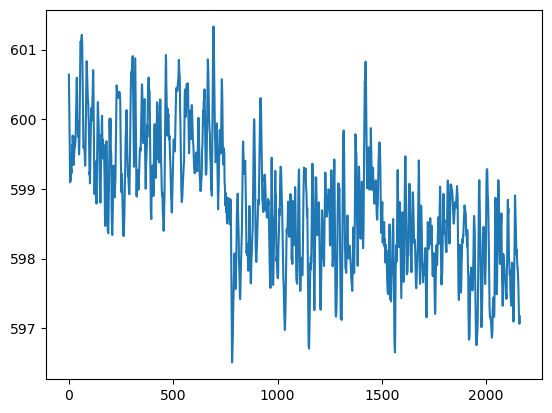

In [81]:
plt.plot(bouts_dict['Fly05182022_5d']['pose.thor_post_x'][0])

In [163]:
def plot_iso_results(fly_data, outliers_fractions):
    scaler = StandardScaler()
    np_scaled = scaler.fit_transform(fly_data)
    data = pd.DataFrame(np_scaled)

    column_names = [f'data_points_{feat_num}' for feat_num in range(fly_data.shape[1])]
    org_data = pd.DataFrame(fly_data, columns=column_names)

    num_subplots = len(outliers_fractions)
    num_cols = 2  # Set the number of columns for the subplot grid
    num_rows = (num_subplots + num_cols - 1) // num_cols  # Calculate the number of rows

    # Create subplots with a grid layout
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

    # Flatten the axes array if necessary
    axes = axes.flatten()
    for i, param in enumerate(outliers_fractions):
        model = IsolationForest(contamination=param)
        model.fit(data)

        org_data[f'anomaly[{param}]'] = model.predict(data)
        a = org_data.loc[org_data[f'anomaly[{param}]'] == -1, ['data_points_0']] #anomaly

        axes[i].plot(org_data.index, org_data['data_points_0'], color='black', label = 'Normal')
        axes[i].scatter(a.index, a['data_points_0'], color='red', label = 'Anomaly')
        axes[i].set_title(f"Contamination = {param}")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

In [84]:
def create_input_data(fly, experiment, features):
    
    input_data = bouts_dict[fly][features[0]][experiment].reshape(-1,1)

    for i in range(1, len(features)):
        input_data = np.concatenate((input_data,
                                    bouts_dict[fly][features[i]][experiment].reshape(-1,1)),
                                    axis=1)
    return input_data

### Analyzing Effect of Features and Outlier Contamination

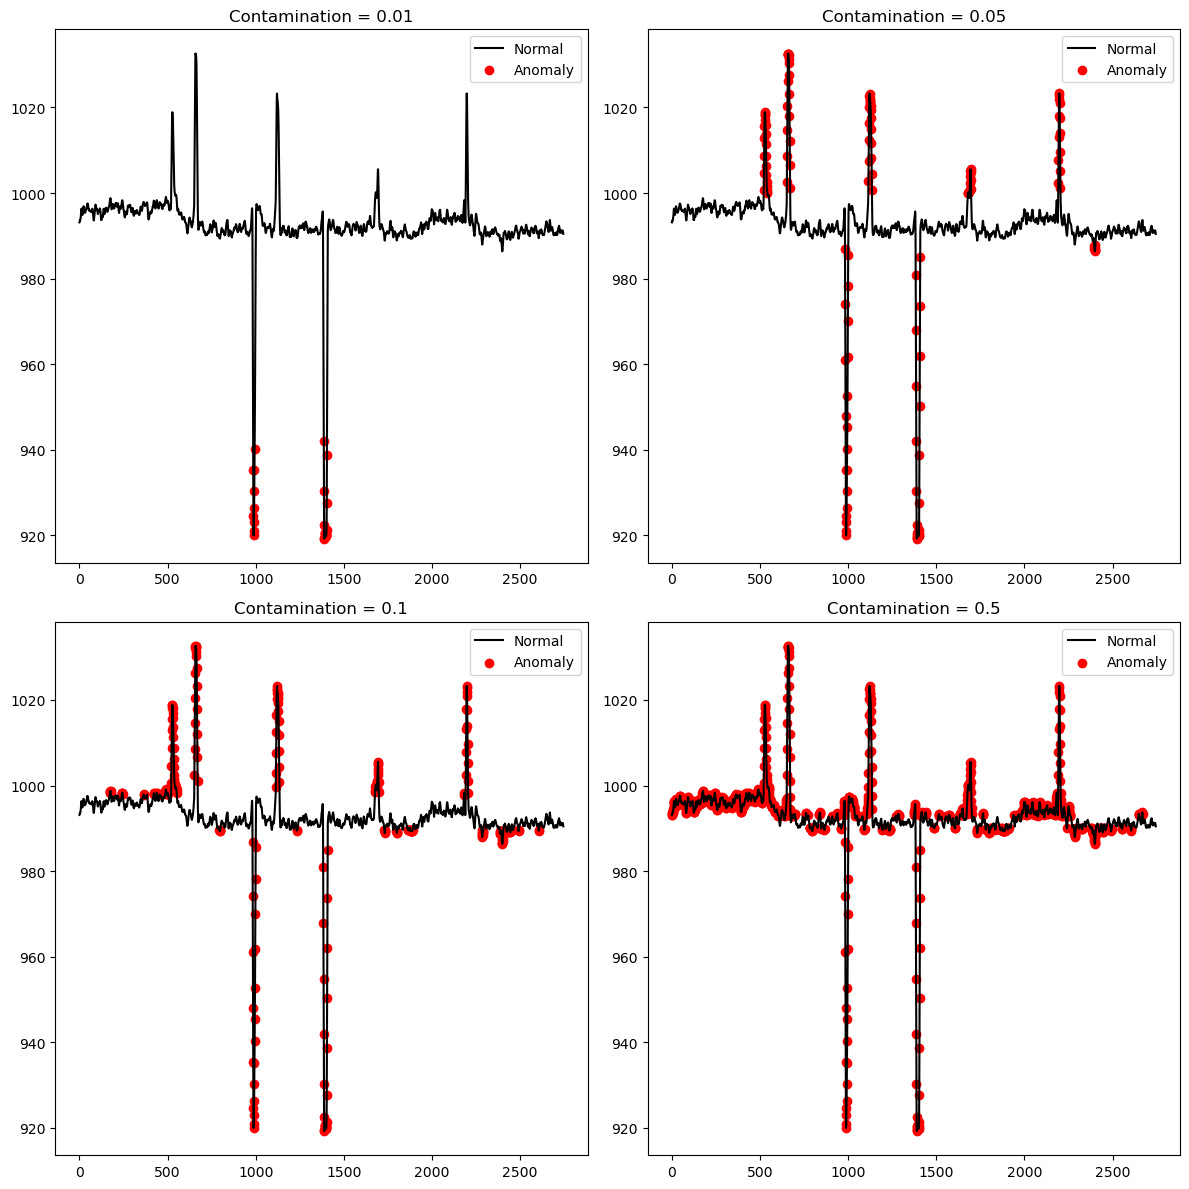

In [91]:
input_data = create_input_data(fly = 'Fly05182022_5d',
                               experiment = 3,
                               features = ['distance.origin-prob'])

plot_iso_results(input_data, [0.01, 0.05, 0.1, 0.5])

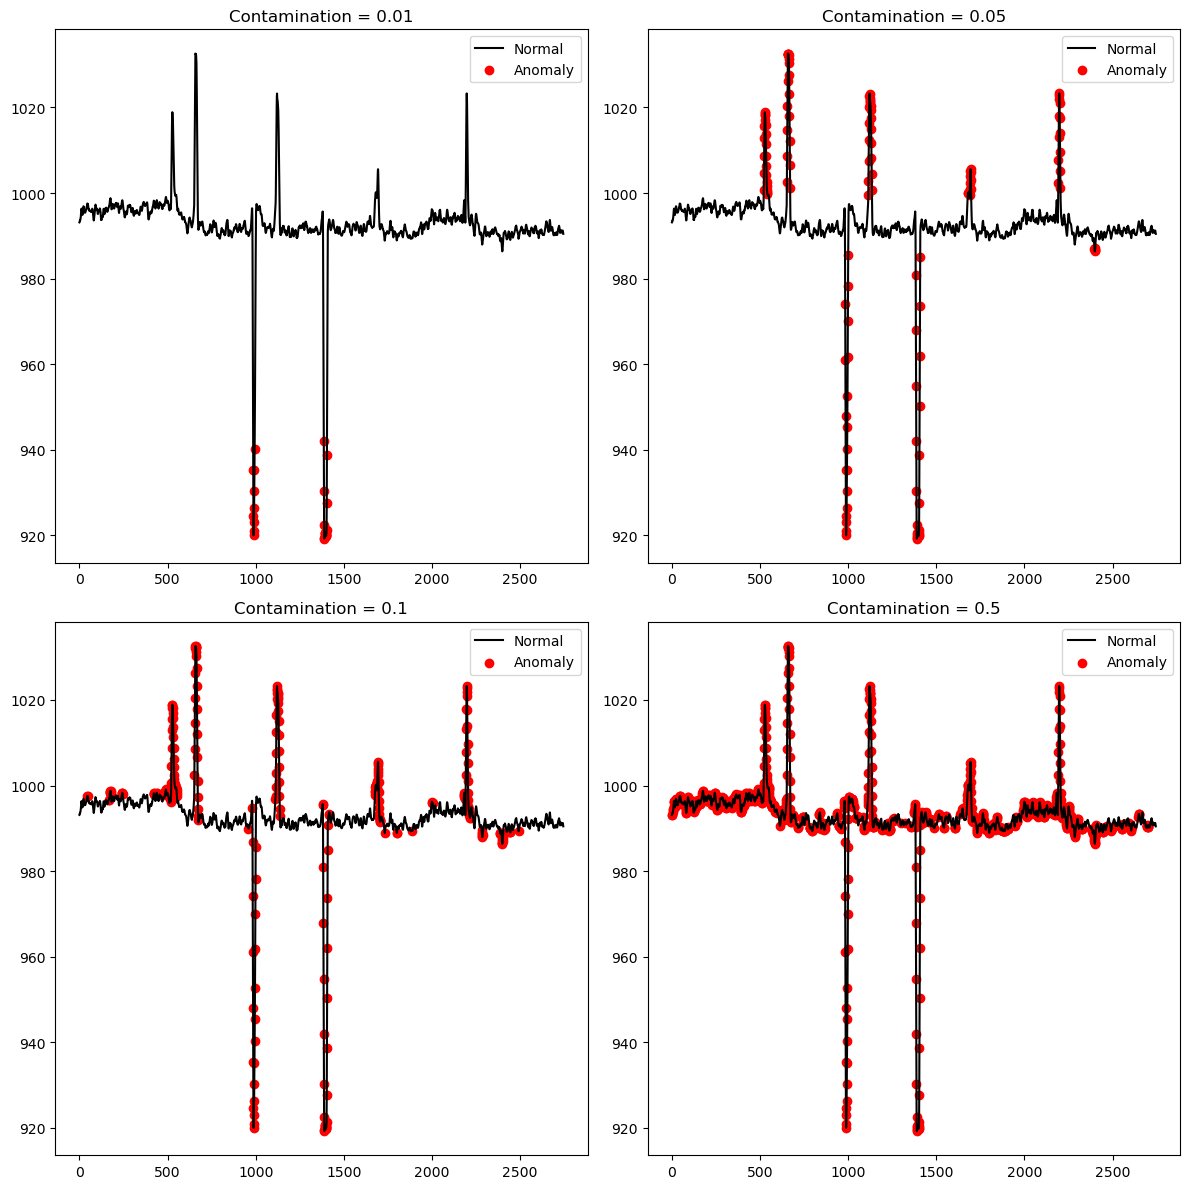

In [89]:
input_data = create_input_data(fly = 'Fly05182022_5d',
                               experiment = 3,
                               features = ['distance.origin-prob',
                                           'distance.head-prob',
                                           'pose.prob_x',
                                           'pose.prob_y'])
plot_iso_results(input_data, [0.01, 0.05, 0.1, 0.5])

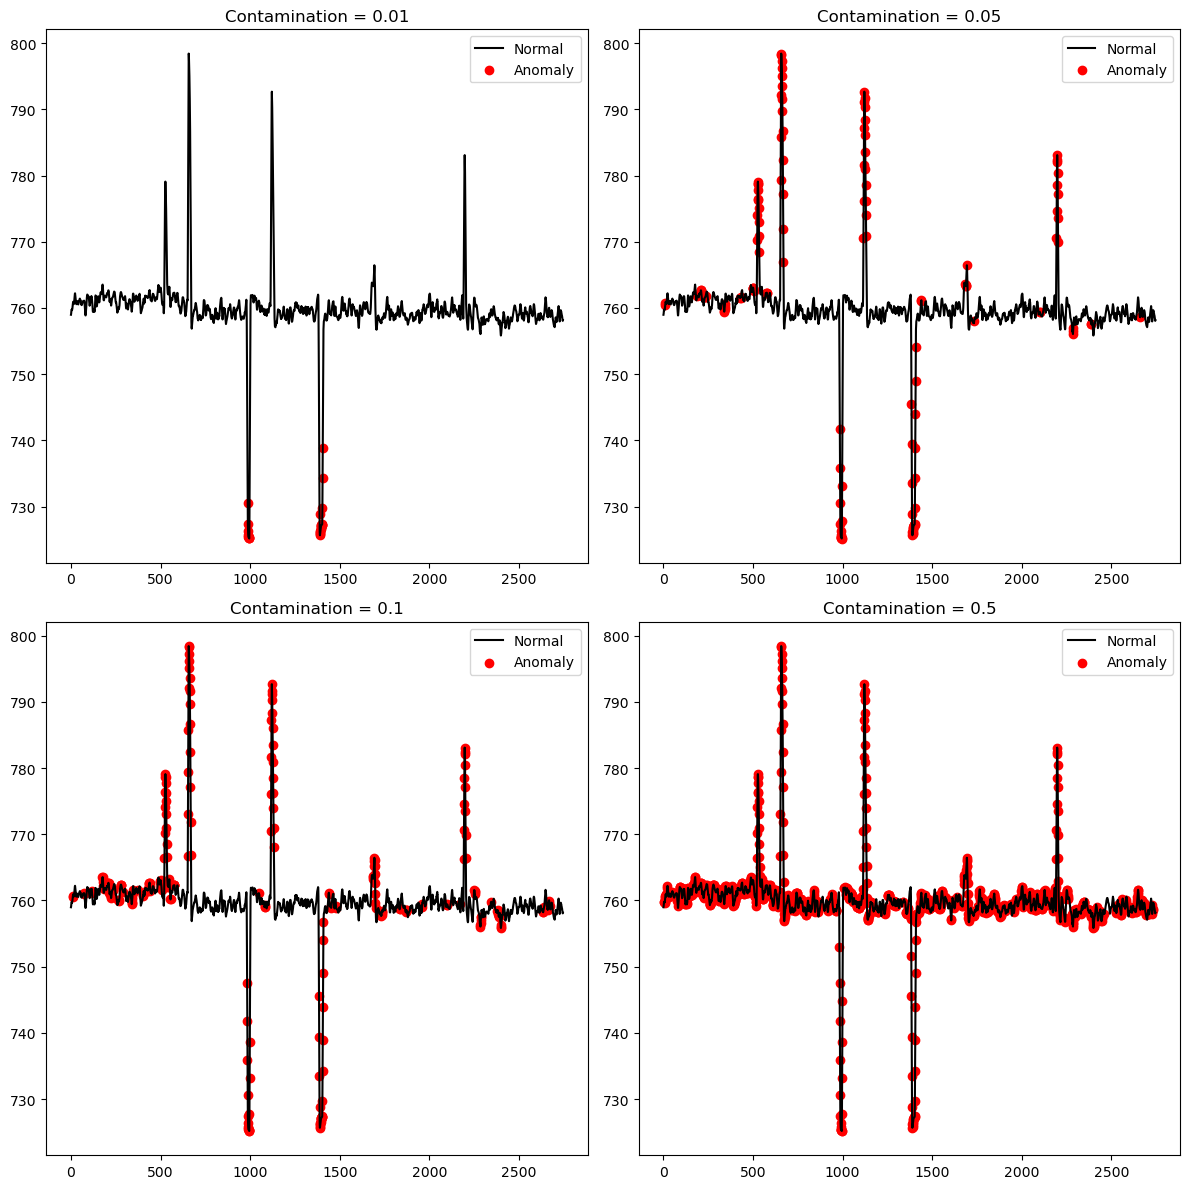

In [87]:
input_data = create_input_data(fly = 'Fly05182022_5d',
                               experiment = 3,
                               features = FEATURES)
plot_iso_results(input_data, [0.01, 0.05, 0.1, 0.5])

### Using Best 4 Features Analyze the Effect of Outlier Contamination

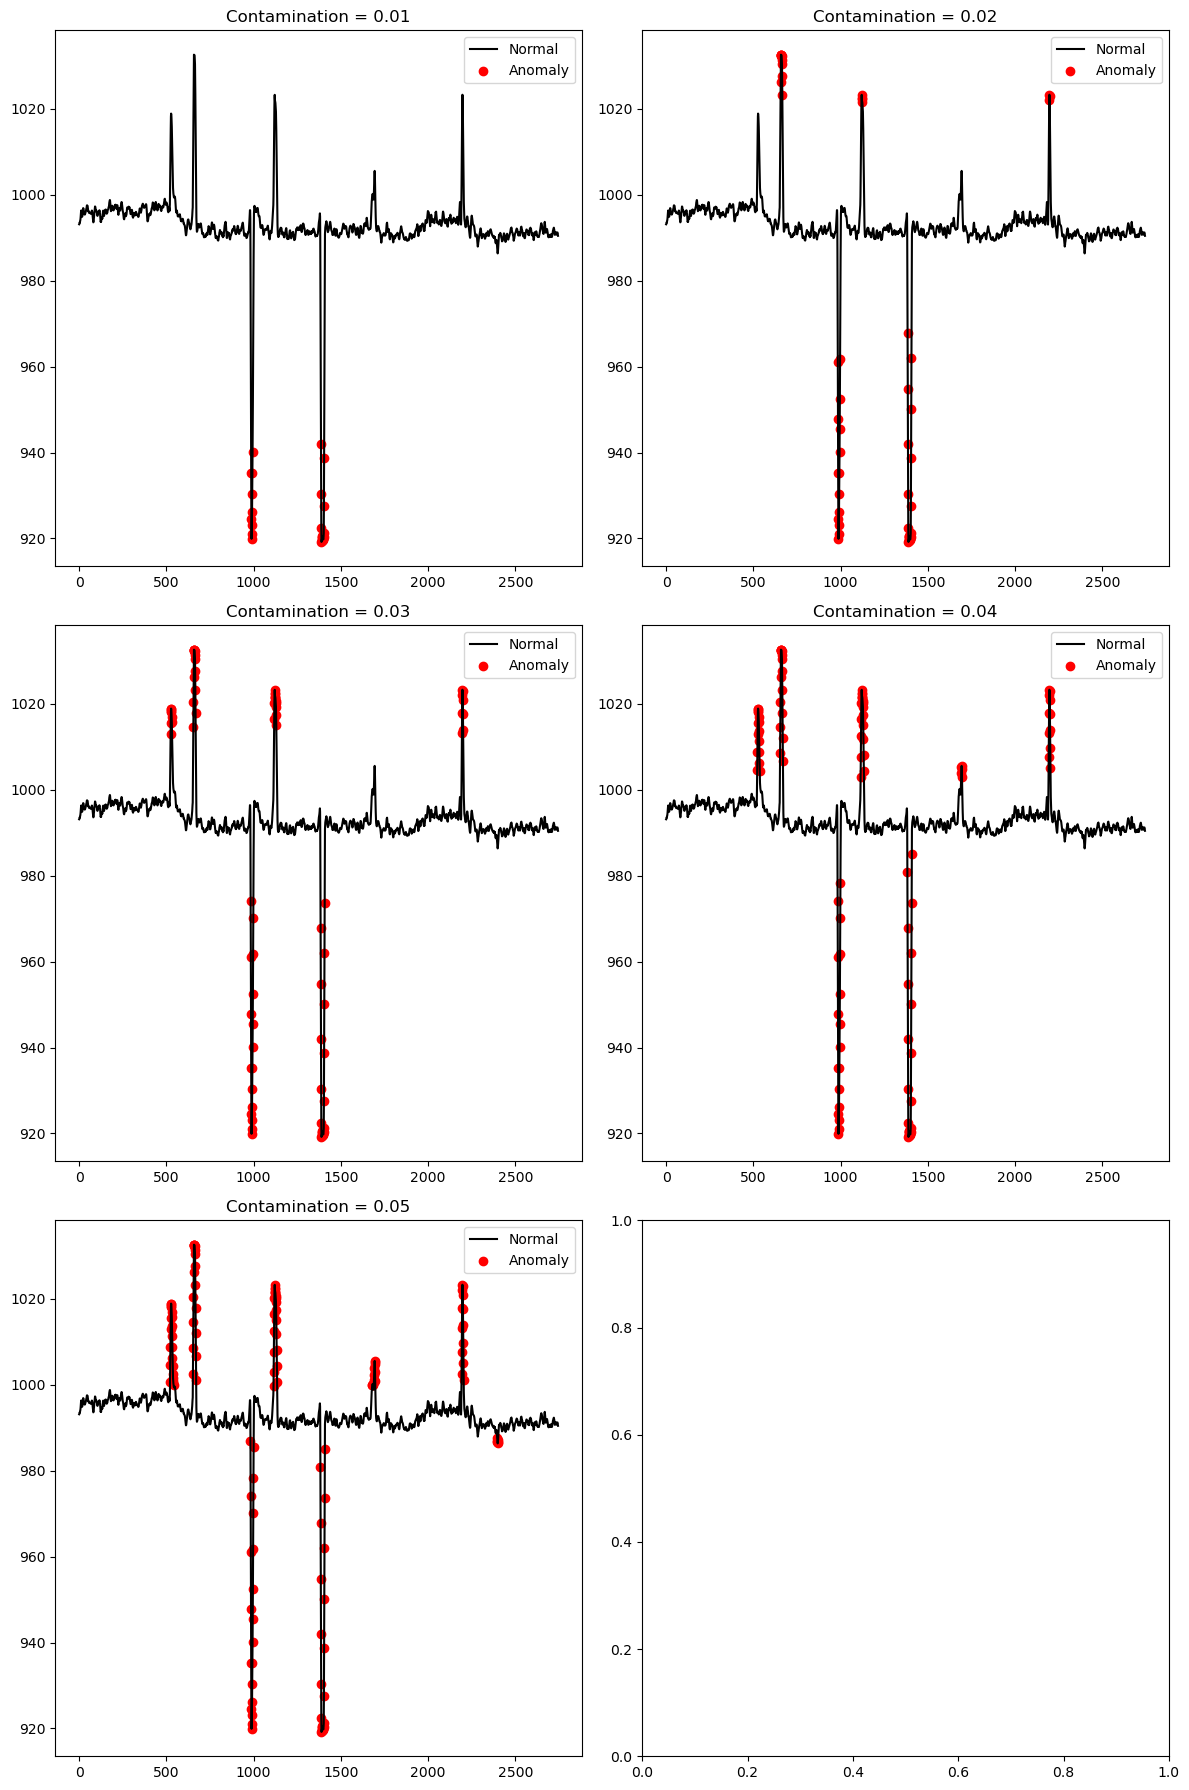

In [94]:
input_data = create_input_data(fly = 'Fly05182022_5d',
                               experiment = 3,
                               features = ['distance.origin-prob',
                                           'distance.head-prob',
                                           'pose.prob_x',
                                           'pose.prob_y'])
plot_iso_results(input_data, [0.01, 0.02, 0.03, 0.04, 0.05])

### Trying to Find Mean Outlier Ratio in Data

In [111]:
true_peak_fn = os.path.join(DATA_PATH, 'true_peak_annotations.npy')
true_peak_df_fn = os.path.join(DATA_PATH, 'true_annotations.pkl')

true_peak_annotations_array = np.load(true_peak_fn)
with open(true_peak_df_fn, 'rb') as f:
    true_peak_annotations_df = pickle.load(f)

In [208]:
true_peak_annotations_df

,peak_index,value,trial_id,name
0,534,1014.361120,0,Fly05182022_5d
1,694,1017.733769,0,Fly05182022_5d
2,903,1027.228163,0,Fly05182022_5d
3,1207,1021.721591,0,Fly05182022_5d
4,1623,1023.545935,0,Fly05182022_5d
...,...,...,...,...
2878,826,596.487973,7,Fly07262022_6d_SD_A
2879,892,597.300351,7,Fly07262022_6d_SD_A
2880,961,598.255978,7,Fly07262022_6d_SD_A
2881,1038,596.704468,7,Fly07262022_6d_SD_A


In [154]:
class FlyInfo:
    def __init__(self, name, trial_id, peak_index, peak_values):
        self.name = name
        self.trial_id = trial_id
        self.peak_index = peak_index
        self.peak_values = peak_values

class FlyDatabase:
    def __init__(self):
        self.fly_data = []

    def add_fly(self, fly_info):
        self.fly_data.append(fly_info)

    def get_fly(self, name, trial_id):
        for fly_info in self.fly_data:
            if fly_info.name == name and fly_info.trial_id == trial_id:
                return fly_info
        return None
    
    def write_fly_info(self, name, trial_id):
        for fly_info in self.fly_data:
            if fly_info.name == name and fly_info.trial_id == trial_id:
                print('Name:', fly_info.name)
                print('Trial Id:', fly_info.trial_id)
                print('Peak Index:', fly_info.peak_index)
                print('Peak Values:', fly_info.peak_values)
                return None
        print('Fly not found!!!')
        return None

In [155]:
fly_db = FlyDatabase()

In [156]:
fly_names = true_peak_annotations_df['name'].unique()

for name in fly_names:
    trial_idxs = true_peak_annotations_df[true_peak_annotations_df['name'] == name]['trial_id'].unique().tolist()
    for idx in trial_idxs:
        peak_index = true_peak_annotations_df[(true_peak_annotations_df['name'] == name) & (true_peak_annotations_df['trial_id'] == idx)]['peak_index'].values
        peak_values = true_peak_annotations_df[(true_peak_annotations_df['name'] == name) & (true_peak_annotations_df['trial_id'] == idx)]['value'].values
        fly_db.add_fly(FlyInfo(name, idx, peak_index, peak_values))

In [157]:
fly_db.write_fly_info('Fly05182022_5d', '0')


Name: Fly05182022_5d
Trial Id: 0
Peak Index: [ 534  694  903 1207 1623]
Peak Values: [1014.36112044 1017.73376888 1027.22816309 1021.72159098 1023.54593544]


In [151]:
peak_ratios = []
for fly in fly_db.fly_data:
    data_length = len(bouts_dict[fly.name].loc[int(fly.trial_id)]['distance.origin-prob'])
    peak_amount = len(fly.peak_index)
    peak_ratios.append(peak_amount / data_length)

peak_ratio = np.mean(peak_ratios)
max_ratio = np.max(peak_ratios)
min_ratio = np.min(peak_ratios)

print(f'Ratio: {peak_ratio}, Min: {min_ratio}, Max: {max_ratio}')

Ratio: 0.003377344961379769, Min: 0.00030807147258163895, Max: 0.01078167115902965


### Analyzing Different Flies with Outlier Contamination

Name: Fly05182022_5d
Trial Id: 25
Peak Index: [710 804 895 996]
Peak Values: [641.98539994 641.84454949 634.51586992 644.63542122]


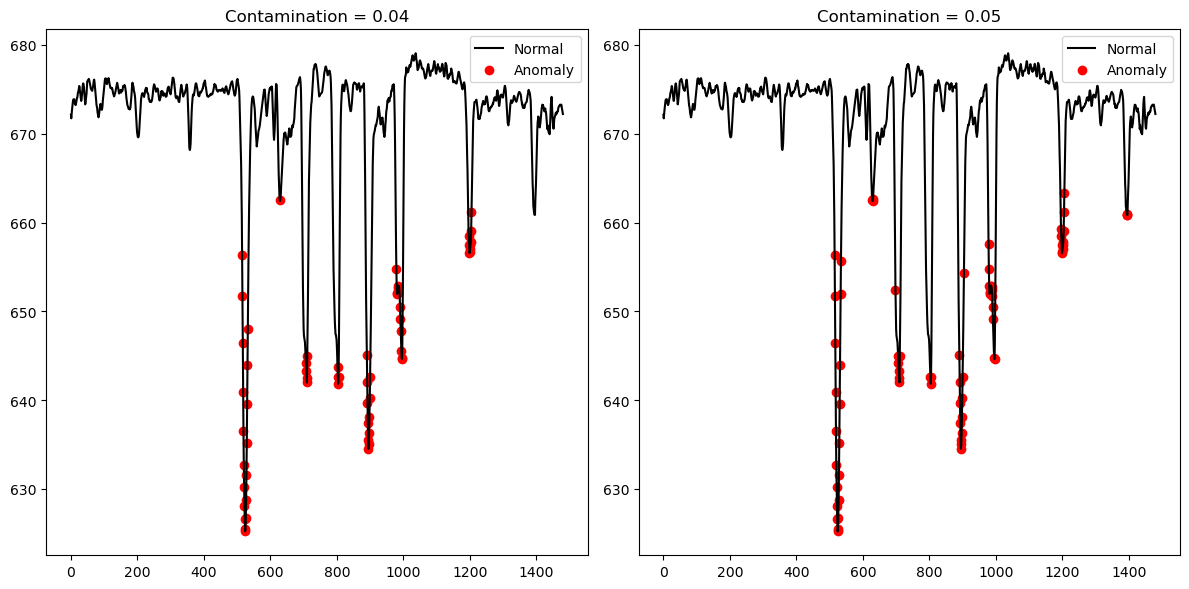

In [177]:
fly_db.write_fly_info('Fly05182022_5d', '25')

input_data = create_input_data(fly = 'Fly05182022_5d',
                               experiment = 25,
                               features = ['distance.origin-prob',
                                           'distance.head-prob',
                                           'pose.prob_x',
                                           'pose.prob_y'])
plot_iso_results(input_data, [0.04, 0.05])

### Evaluation

In [412]:
def calculate_evaluation_metrics(predicted_peaks, true_peaks, matching_range, use_precision=False):
    recall_predictions = []
    precision_predictions = []

    for true_idx in true_peaks:
        found_true_pred = False
        for pred_idx in predicted_peaks:
            if abs(pred_idx - true_idx) <= matching_range:
                found_true_pred = True
                break
        recall_predictions.append(found_true_pred)
    
    if use_precision:
        for pred_idx in predicted_peaks:
            found_true_pred = False
            for true_idx in true_peaks:
                if abs(pred_idx - true_idx) <= matching_range:
                    found_true_pred = True
                    break
            precision_predictions.append(found_true_pred)

    recall = np.sum(recall_predictions) / len(recall_predictions)
    precision = np.sum(precision_predictions) / len(precision_predictions) if use_precision else None
    return recall, precision

def evaluate_results(all_results, matching_range = 30, use_precision=False):
    avg_recall, avg_precision = 0, 0
    all_recalls, all_precision = [], []
    
    for res in all_results:
        predicted_peaks = res['predicted_index']
        true_peaks = res['true_index']
        
        recall, precision = calculate_evaluation_metrics(predicted_peaks, true_peaks, matching_range, use_precision)
        all_recalls.append(recall)
        avg_recall += recall
        if use_precision:
            all_precision.append(precision)
            avg_precision += precision

    avg_recall /= len(all_results)
    if precision:
        avg_precision = avg_precision / len(all_results)
    
    return avg_recall, all_recalls, avg_precision, all_precision

In [200]:
model_features = ['distance.origin-prob',
                  'distance.head-prob',
                  'pose.prob_x',
                  'pose.prob_y']

all_results = []

for fly in fly_db.fly_data:
    input_data = create_input_data(fly = fly.name,
                                   experiment = int(fly.trial_id),
                                   features = model_features)
    
    info_df = pd.DataFrame(input_data, columns = model_features)
    scaled_data = StandardScaler().fit_transform(input_data)
    model = IsolationForest(contamination=0.04)
    info_df['predictions'] = model.fit_predict(scaled_data)
    anomalies_idx = list(info_df.loc[info_df['predictions'] == -1, ['distance.origin-prob']].index)
    all_results.append({'true_index': fly.peak_index, 'predicted_index': anomalies_idx})

avg_recall, all_recalls = evaluate_results(all_results)
print('Recall:', avg_recall)

Recall: 0.8218121024183253


Index 20 has recall of 0.0. Take a look at that below

Name: Fly05202022_5d
Trial Id: 5
Peak Index: [1242 1362]
Peak Values: [306.3470232  306.76456177]


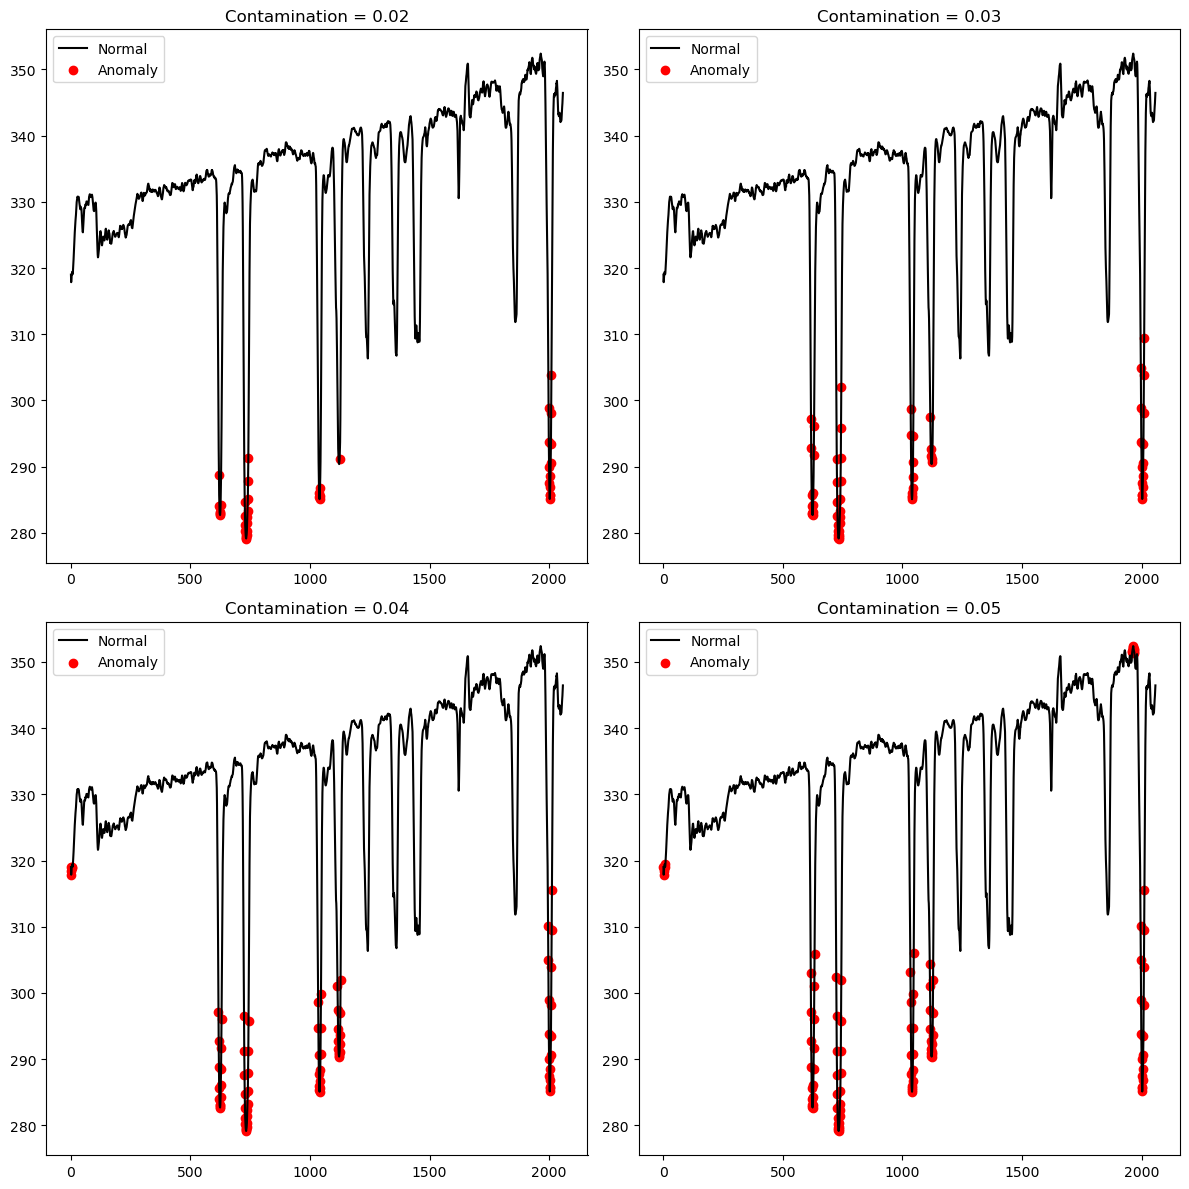

In [209]:
fly = fly_db.fly_data[20]

fly_db.write_fly_info(fly.name, fly.trial_id)

input_data = create_input_data(fly = fly.name,
                                   experiment = int(fly.trial_id),
                                   features = model_features)
    
plot_iso_results(input_data, [0.02, 0.03, 0.04, 0.05])

### Hyperparameter Analyze for Isolation Forest Algorithm

Name: Fly06072022_5d
Trial Id: 36
Peak Index: [ 713  778  842  906  973 1054]
Peak Values: [1002.83915479  992.92055866  992.82376002  992.00544614  993.34117482
  990.16313952]
Recall: 1.0


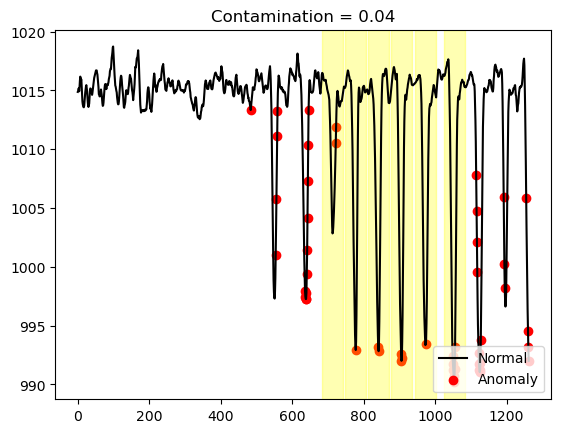

In [286]:
fly = fly_db.fly_data[102]

fly_db.write_fly_info(fly.name, fly.trial_id)

input_data = create_input_data(fly = fly.name,
                               experiment = int(fly.trial_id),
                               features = model_features)
    
info_df = pd.DataFrame(input_data, columns = model_features)
scaled_data = StandardScaler().fit_transform(input_data)

model = IsolationForest(n_estimators = 100,
                        contamination=0.04,
                        max_samples='auto',
                        max_features=1.0,
                        bootstrap=False)

info_df['predictions'] = model.fit_predict(scaled_data)
anomalies = info_df.loc[info_df['predictions'] == -1, ['distance.origin-prob']]
anomalies_idx = list(anomalies.index)

recall = calculate_evaluation_metrics(anomalies_idx, fly.peak_index, matching_range = 30)
print('Recall:', recall)

plt.plot(info_df.index, info_df[model_features[0]], color='black', label = 'Normal')
plt.scatter(anomalies.index, anomalies[model_features[0]], color='red', label = 'Anomaly')

for true_peaks in fly.peak_index:
    min_range, max_range = true_peaks - 30, true_peaks + 30
    plt.axvspan(min_range, max_range, color='yellow', alpha=0.3)

plt.title(f"Contamination = {0.04}")
plt.legend(loc='lower right', prop = {'size': 10})
plt.show()

### From Predictions -/+ 30, Get Min/Max Predictions

In [327]:
def filter_prediction(anomalies, grouped_range=60):
    idx_group = []
    all_groups = []
    for idx in list(anomalies.index):
        if idx in idx_group:
            continue
        idx_group = []
        for i in range(idx, idx+grouped_range):
            if i in list(anomalies.index):
                idx_group.append(i)
        all_groups.append(idx_group)
    
    group_pred_idx = []
    group_pred_val = []
    for group in all_groups:
        group_vals = anomalies.loc[group]['distance.origin-prob']
        if len(group_vals) > 1 and group_vals.iloc[0] < group_vals.iloc[1]:
            pred = group_vals[group_vals == group_vals.max()]
        else:
            pred = group_vals[group_vals == group_vals.min()]
        group_pred_idx.append(pred.index.values[0])
        group_pred_val.append(pred.values[0])
    return group_pred_idx, group_pred_val

Name: Fly05182022_5d
Trial Id: 15
Peak Index: [ 598  775  954 1179 1690]
Peak Values: [605.81743505 589.91734126 589.48125274 604.79549692 591.13223948]
Recall: 1.0


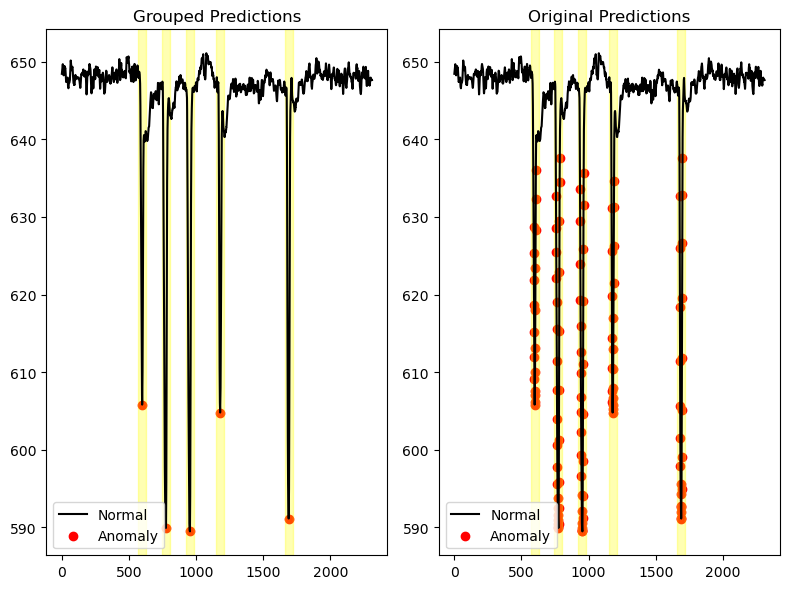

In [347]:
fly = fly_db.fly_data[9]

fly_db.write_fly_info(fly.name, fly.trial_id)

input_data = create_input_data(fly = fly.name,
                               experiment = int(fly.trial_id),
                               features = model_features)
    
info_df = pd.DataFrame(input_data, columns = model_features)
scaled_data = StandardScaler().fit_transform(input_data)

model = IsolationForest(n_estimators = 100,
                        contamination=0.05,
                        max_samples='auto',
                        max_features=1.0,
                        bootstrap=False)

info_df['predictions'] = model.fit_predict(scaled_data)
anomalies = info_df.loc[info_df['predictions'] == -1, ['distance.origin-prob']]
anomalies_idx = list(anomalies.index)

group_pred_idx, group_pred_val = filter_prediction(anomalies, grouped_range=60)

recall = calculate_evaluation_metrics(group_pred_idx, fly.peak_index, matching_range = 30)
print('Recall:', recall)

fig, axes = plt.subplots(1, 2, figsize=(8, 6))
axes = axes.flatten()

axes[0].plot(info_df.index, info_df[model_features[0]], color='black', label = 'Normal')
axes[0].scatter(group_pred_idx, group_pred_val, color='red', label = 'Anomaly')
axes[1].plot(info_df.index, info_df[model_features[0]], color='black', label = 'Normal')
axes[1].scatter(anomalies.index, anomalies[model_features[0]], color='red', label = 'Anomaly')

for true_peaks in fly.peak_index:
    min_range, max_range = true_peaks - 30, true_peaks + 30
    axes[0].axvspan(min_range, max_range, color='yellow', alpha=0.3)
    axes[1].axvspan(min_range, max_range, color='yellow', alpha=0.3)

axes[0].set_title("Grouped Predictions")
axes[0].legend()
axes[1].set_title("Original Predictions")
axes[1].legend()
plt.tight_layout()
plt.show()

### Comparing Robust covariance, One-Class SVM, Isolation Forest and Local Outlier Factor

In [421]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def generate_pred_plots(model, example=0):
    fly = fly_db.fly_data[example]

    fly_db.write_fly_info(fly.name, fly.trial_id)

    input_data = create_input_data(fly = fly.name,
                                experiment = int(fly.trial_id),
                                features = model_features)
        
    info_df = pd.DataFrame(input_data, columns = model_features)
    scaled_data = StandardScaler().fit_transform(input_data)

    info_df['predictions'] = model.fit_predict(scaled_data)
    anomalies = info_df.loc[info_df['predictions'] == -1, ['distance.origin-prob']]
    anomalies_idx = list(anomalies.index)

    group_pred_idx, group_pred_val = filter_prediction(anomalies, grouped_range=60)

    recall_group, _ = calculate_evaluation_metrics(group_pred_idx, fly.peak_index, matching_range = 30)
    recall, _ = calculate_evaluation_metrics(anomalies_idx, fly.peak_index, matching_range = 30)
    print('Recall:', recall)
    print('Grouped Recall:', recall_group)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes = axes.flatten()

    axes[0].plot(info_df.index, info_df[model_features[0]], color='black', label = 'Normal')
    axes[0].scatter(anomalies.index, anomalies[model_features[0]], color='red', label = 'Anomaly')
    axes[1].plot(info_df.index, info_df[model_features[0]], color='black', label = 'Normal')
    axes[1].scatter(group_pred_idx, group_pred_val, color='red', label = 'Anomaly')


    for true_peaks in fly.peak_index:
        min_range, max_range = true_peaks - 30, true_peaks + 30
        axes[0].axvspan(min_range, max_range, color='yellow', alpha=0.3)
        axes[1].axvspan(min_range, max_range, color='yellow', alpha=0.3)

    axes[0].set_title(f"Method 1 - All Predictions - Recall:{round(recall,2)}")
    axes[0].legend()
    axes[1].set_title(f"Method 2 - Filtered Predictions - Recall:{round(recall_group,2)}")
    axes[1].legend()
    plt.tight_layout()
    plt.show()

Name: Fly06302022_5d_A
Trial Id: 61
Peak Index: [ 992 1107 1226 1336 1417 1575 1669 1741 1823 1902 1991 2083 2163 2252
 2339 2440 2539]
Peak Values: [266.14769845 265.31945901 265.93512176 265.45042672 266.28794223
 267.32825973 266.99193851 264.87310303 266.85442119 266.87410836
 266.46009773 266.65743497 265.7211598  266.31217476 266.03074107
 267.89787608 267.30649637]


Recall: 0.9411764705882353
Grouped Recall: 0.9411764705882353


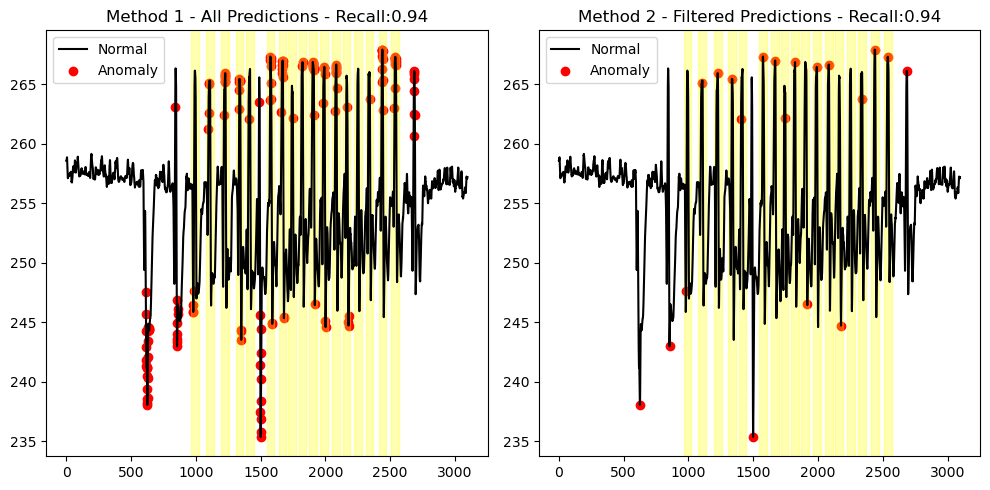

In [427]:
iso_model = IsolationForest(n_estimators = 100,
                            contamination=0.04,
                            max_samples='auto',
                            max_features=1.0,
                            bootstrap=False)
generate_pred_plots(iso_model, example=300)

Name: Fly05182022_5d
Trial Id: 0
Peak Index: [ 534  694  903 1207 1623]
Peak Values: [1014.36112044 1017.73376888 1027.22816309 1021.72159098 1023.54593544]
Recall: 1.0
Grouped Recall: 0.8


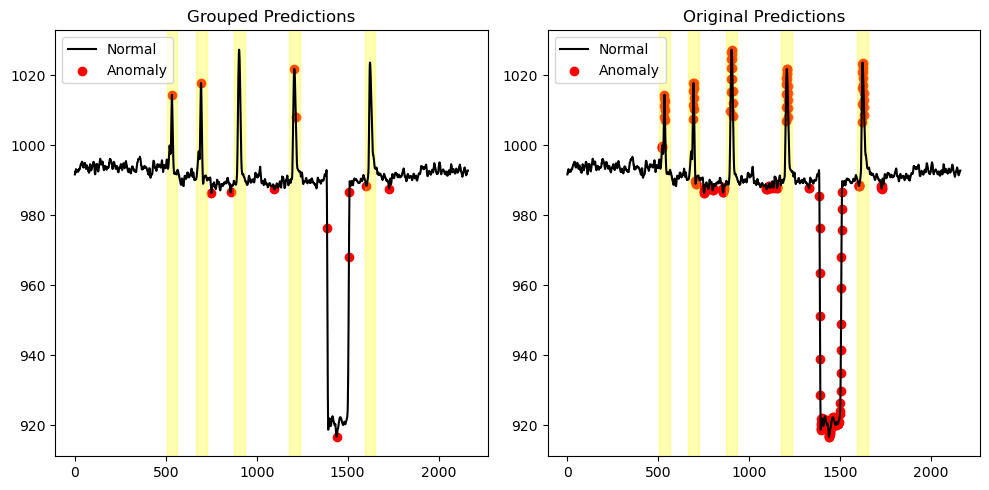

In [385]:
svm_model = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
generate_pred_plots(svm_model, example=0)

Name: Fly05182022_5d
Trial Id: 7
Peak Index: [ 543  649  746  841  927 1147]
Peak Values: [294.23604399 275.40238923 275.10835361 279.38176044 278.34630204
 282.24037742]
Recall: 0.8333333333333334


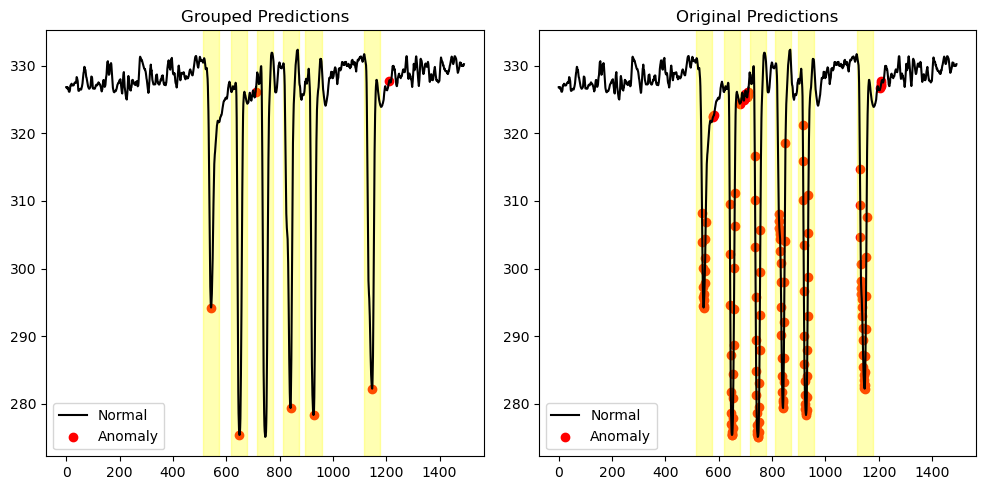

In [373]:
ell_model =  EllipticEnvelope(contamination=0.1, random_state=42)
generate_pred_plots(ell_model, example=4)

Name: Fly05182022_5d
Trial Id: 0
Peak Index: [ 534  694  903 1207 1623]
Peak Values: [1014.36112044 1017.73376888 1027.22816309 1021.72159098 1023.54593544]
Recall: 1.0


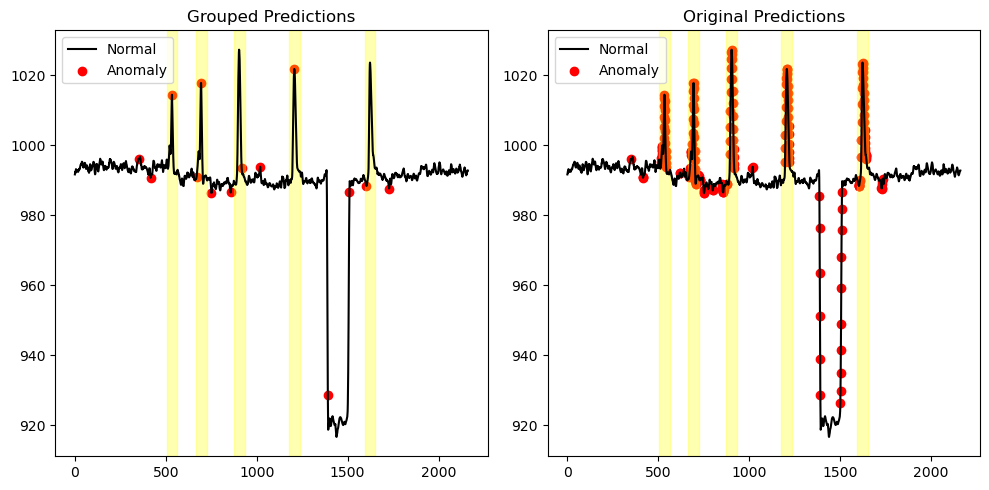

In [372]:
lof_model = LocalOutlierFactor(n_neighbors=100, contamination=0.1)
generate_pred_plots(lof_model, example=0)

### Evaluate Final Model

In [426]:
model_features = ['distance.origin-prob',
                  'distance.head-prob',
                  'pose.prob_x',
                  'pose.prob_y']

all_results = []
all_results_group = []

for fly in fly_db.fly_data:
    input_data = create_input_data(fly = fly.name,
                                   experiment = int(fly.trial_id),
                                   features = model_features)
    
    info_df = pd.DataFrame(input_data, columns = model_features)
    scaled_data = StandardScaler().fit_transform(input_data)
    model = IsolationForest(n_estimators = 100,
                            contamination=0.04,
                            max_samples='auto',
                            max_features=1.0,
                            bootstrap=False)
    info_df['predictions'] = model.fit_predict(scaled_data)
    anomalies = info_df.loc[info_df['predictions'] == -1, ['distance.origin-prob']]
    anomalies_idx = list(info_df.loc[info_df['predictions'] == -1, ['distance.origin-prob']].index)

    group_pred_idx, group_pred_val = filter_prediction(anomalies, grouped_range=60)
    
    all_results.append({'true_index': fly.peak_index, 'predicted_index': anomalies_idx})
    all_results_group.append({'true_index': fly.peak_index, 'predicted_index': group_pred_idx})

avg_recall, all_recalls, _, _ = evaluate_results(all_results)
avg_recall_g, all_recalls_g, avg_precision_g, all_precision_g = evaluate_results(all_results_group, use_precision=True)
print('Recall:', avg_recall)
print('Group - Precision:', avg_precision_g,'Group - Recall:', avg_recall_g)

Recall: 0.821895155463067
Group - Precision: 0.7589450812920766 Group - Recall: 0.8048105590866254


Name: Fly06072022_5d
Trial Id: 16
Peak Index: [ 564  707  805  898 1043 1211]
Peak Values: [586.21991635 590.23142433 591.24694744 590.73465606 591.79191183
 592.61680791]
Recall: 1.0
Grouped Recall: 1.0


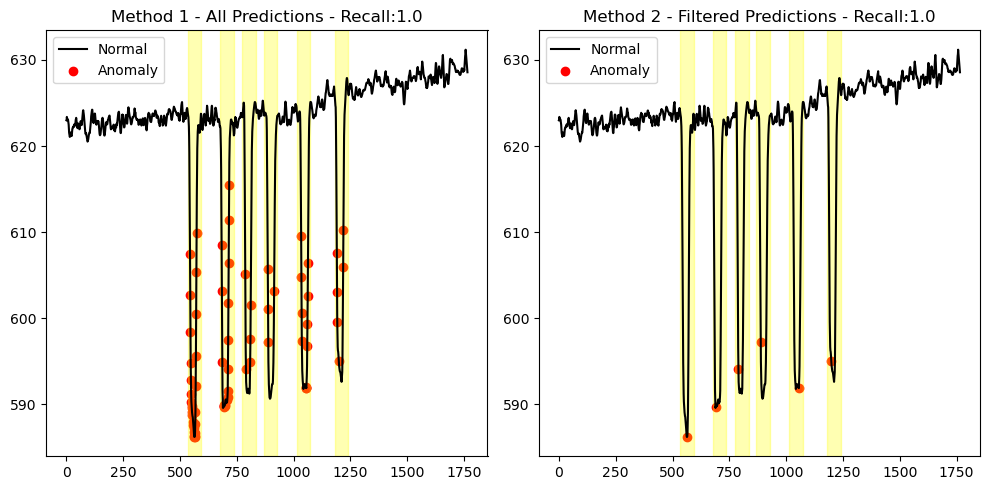

In [425]:
iso_model = IsolationForest(n_estimators = 100,
                            contamination=0.04,
                            max_samples='auto',
                            max_features=1.0,
                            bootstrap=False)
generate_pred_plots(iso_model, example=92)